In [1]:
library(DESeq2)
library(enrichplot)
library(clusterProfiler)
library(org.Hs.eg.db)
library(ggplot2)
library(tidyr)
library(dplyr)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb



In [2]:
deseq_brain = readRDS('../../rds/deseq2_brain_mockvirus.rds')
genes = read.csv('../../output/gut/gut_genes.csv',row.names = 1)

In [11]:
# Define significance criteria (modify if needed)
lfc_threshold <- 0.2
padj_threshold <- 0.3

# Extract significantly differentially expressed genes for each virus set
sig_MLB2 <- rownames(deseq_brain$MLB2)[
  which(abs(deseq_brain$MLB2$log2FoldChange) > lfc_threshold &
        deseq_brain$MLB2$padj < padj_threshold)
]

sig_VA1 <- rownames(deseq_brain$VA1)[
  which(abs(deseq_brain$VA1$log2FoldChange) > lfc_threshold &
        deseq_brain$VA1$padj < padj_threshold)
]

sig_HAstV4 <- rownames(deseq_brain$HAstV4)[
  which(abs(deseq_brain$HAstV4$log2FoldChange) > lfc_threshold &
        deseq_brain$HAstV4$padj < padj_threshold)
]


In [16]:
print (sig_MLB2)
print (sig_VA1)
print (sig_HAstV4)

[1] "ENSG00000120549"
[1] "ENSG00000117707"
 [1] "ENSG00000117707" "ENSG00000128655" "ENSG00000138741" "ENSG00000052802"
 [5] "ENSG00000112972" "ENSG00000120437" "ENSG00000168298" "ENSG00000186480"
 [9] "ENSG00000171243" "ENSG00000079459" "ENSG00000134996" "ENSG00000006534"
[13] "ENSG00000107611" "ENSG00000120549" "ENSG00000099194" "ENSG00000109107"


In [14]:
# Find the common genes across all three virus conditions
#Reduce(intersect, list(...)) takes the intersection across all lists, resulting in the genes that are significantly differentially expressed in all three virus conditions.
#common_genes <- Reduce(intersect, list(sig_MLB2, sig_VA1, sig_HAstV4))
common_genes <- Reduce(intersect, list(sig_MLB2, sig_VA1))
# Display the common genes
print(common_genes)


character(0)


In [6]:
# Create a summary data frame for the common genes
common_summary <- data.frame(
  gene_id = common_genes,
  MLB2_log2FC = deseq_gundiff$MLB2[common_genes, "log2FoldChange"],
  VA1_log2FC = deseq_gundiff$VA1[common_genes, "log2FoldChange"],
  HAstV4_log2FC = deseq_gundiff$HAstV4[common_genes, "log2FoldChange"]
)

# Add the gene names from the 'genes' data frame.
# We assume the row names of 'genes' match the gene IDs.
common_summary$gene_name <- genes[common_summary$gene_id, "gene_name"]

# Display the summary
print(common_summary)


          gene_id MLB2_log2FC VA1_log2FC HAstV4_log2FC gene_name
1 ENSG00000160781    6.440680   5.872368      6.940963     PAQR6
2 ENSG00000137959    2.864127   8.755425     10.356549    IFI44L
3 ENSG00000128536    6.680516   6.484267      5.966704     CDHR3
4 ENSG00000126787    5.241779   4.031327      4.913290    DLGAP5
5 ENSG00000176749    5.579616   4.809194      5.286932    CDK5R1
6 ENSG00000101347   -1.040909   1.400012      2.806152    SAMHD1


In [7]:
#write.csv(common_summary, file = "gundiff_common_genes_summary.csv", row.names = FALSE)

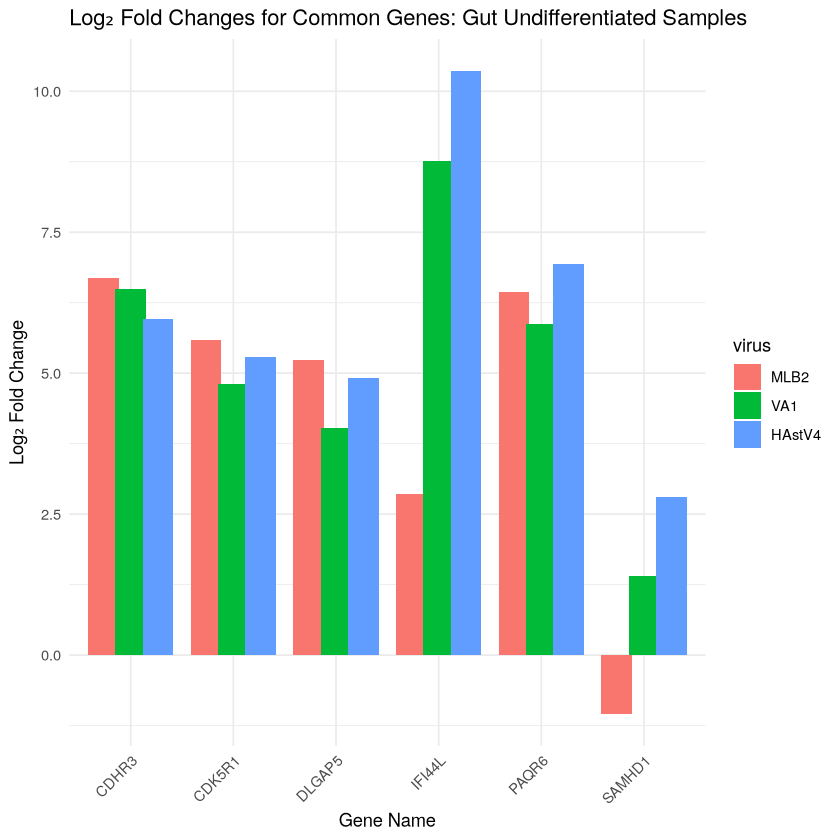

In [10]:
# Reshape data into long format
common_summary_long <- pivot_longer(common_summary,
  cols = c("MLB2_log2FC", "VA1_log2FC", "HAstV4_log2FC"),
  names_to = "virus",
  values_to = "log2FC"
)

# Clean up virus names
common_summary_long$virus <- factor(common_summary_long$virus,
  levels = c("MLB2_log2FC", "VA1_log2FC", "HAstV4_log2FC"),
  labels = c("MLB2", "VA1", "HAstV4")
)

# Create the plot
p <- ggplot(common_summary_long, aes(x = gene_name, y = log2FC, fill = virus)) +
  geom_bar(stat = "identity", position = position_dodge(0.8)) +
  theme_minimal() +
  labs(title = "Log₂ Fold Changes for Common Genes: Gut Undifferentiated Samples",
       x = "Gene Name", y = "Log₂ Fold Change") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

print(p)

#Save the plot as PNG
#ggsave("common_genes_plot.png", p, width = 8, height = 6, dpi = 300)

In [11]:
#Save the plot as PNG
ggsave("gundiff_common_genes_plot.png", p, width = 8, height = 6, dpi = 300)